# Model Train

We are generating dengue case forecasts

Features were generated by script `dataprep.py`

```bash
# running this pushes the data to the database
./scripts/dataprep.py
```

In [50]:
import pandas as pd

from plotnine import ggplot, aes, geom_line, geom_ribbon, xlab, ylab
from dengue.models import INLAForecastModel_V1

# First model

In [20]:
config_file = "/home/wesley/github/etheleon/national_analysis/dengue/models/INLA/config.yaml"
! cat {config_file}

train:
  start_time: 2020-01-01
  end_time: 2022-12-31
test:
  start_time: 2023-01-01
  end_time: 2023-12-31
dataset: national_analysis.inla_model_ds
target: cases
model:
  horizon: 0
  inla:
    family: 'nbinomial'
    offset: 'log(population/100000)'
    control:
      inla:
        strategy: 'adaptive'
      predictor:  # to compute predictions
        link: 1
        compute: true
      compute:
        return.marginals.predictor: true
        dic: true
        waic: true
        cpo: true
        config: true
      fixed: 
        correlation.matrix: true
        prec.intercept: 1
        prec: 1
    num.threads: 4
    verbose: false
  hyperparameters: 
    - prec:
        prior: 'pc.prec'
        param: [0.5,x: 0.01]
features:
  - name: days_since_switch
    variable_type: group
    bins: 18
    model: 'rw2'
    scale_model: 'TRUE'
  - name: max_t_scale_12_wk_avg_0
    variable_type: group
    bins: 25
    model: 'rw2'
    scale_model: 'TRUE'
  - name: nino34_12_wk_avg_4
    vari

## Fit model

In [ ]:
model = INLAForecastModel_V1(config_file)
model.generateDataset()
model.fit()

In [10]:
# with observed cases
input_data = model.get_data()

In [6]:
# with predicted cases
fitted_values_df = model.get_fitted_values()

## Plot Values

In [ ]:
indata = input_data.loc[:, ["date", "cases_actual"]].assign(lower=0).assign(upper=0).assign(cases="observed").rename(columns={"cases_actual":"mean"})
plot_df = pd.concat([
    fitted_values_df.assign(cases="predicted"),
    indata
])
plot_df['date'] = pd.to_datetime(plot_df['date'], format="%Y-%m-%d")

/home/wesley/.cache/pypoetry/virtualenvs/dengue-jbzOTZFf-py3.13/lib/python3.13/site-packages/plotnine/geoms/geom_path.py:99: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


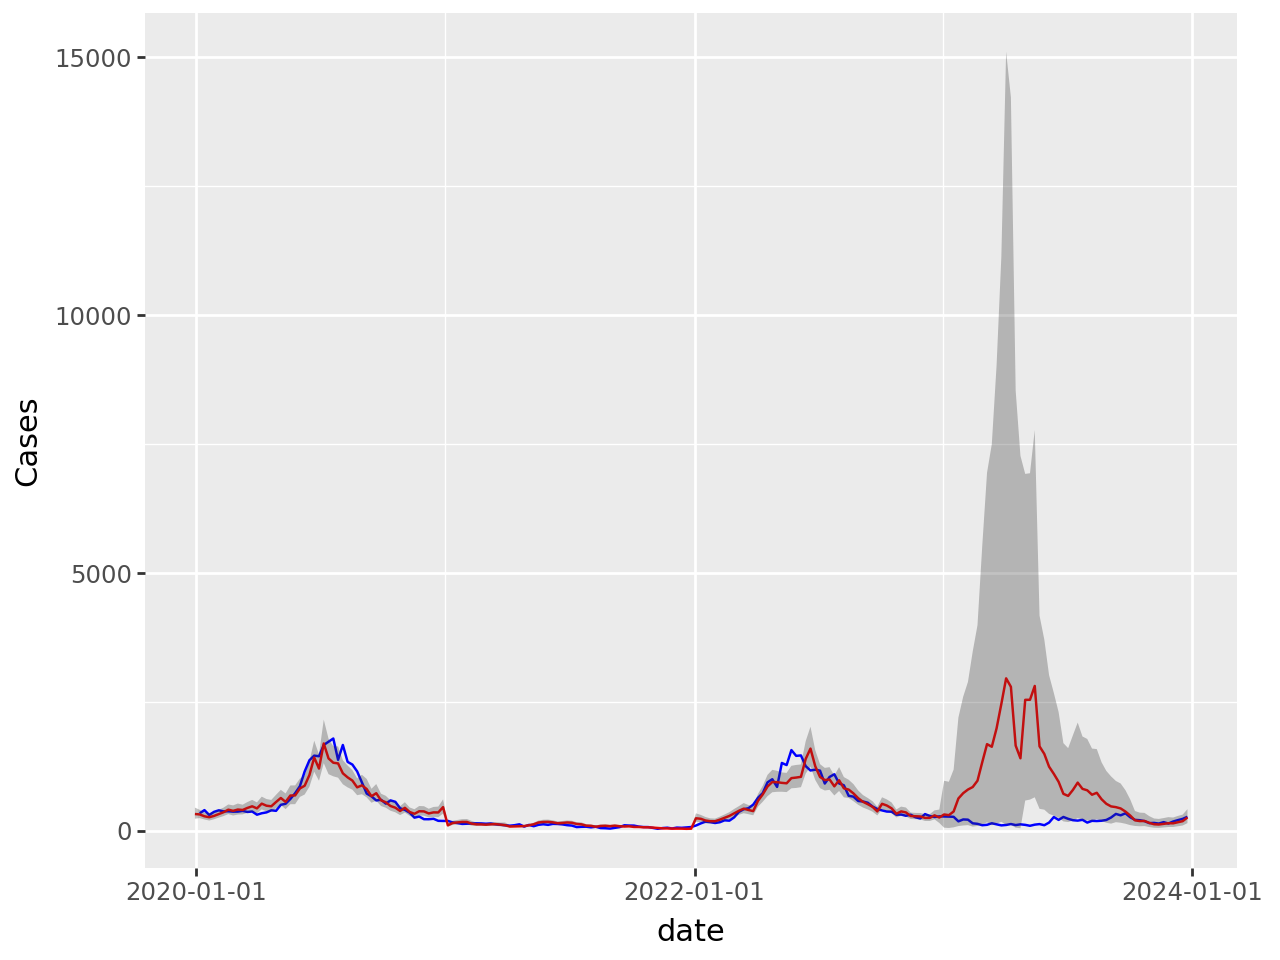

In [51]:
(
    ggplot()
    + geom_line(plot_df.query("cases == 'observed'"), aes("date", "mean"), color="blue")
    + geom_line(plot_df.query("cases == 'predicted'"), aes("date", "mean"), color="red")
    + geom_ribbon(plot_df.query("cases == 'predicted'"), aes(x="date", y="mean", ymin="lower", ymax="upper"), alpha=0.3)
    + ylab("Cases")
)